## Libraries

In [1]:
import json 
import timeit
import math 
import nltk
import csv
import textblob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from math import log, exp
from numpy.linalg import inv
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

start = timeit.default_timer()

/Users/memalette/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/memalette/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/memalette/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/memalette/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Functions

In [2]:
def data_split(X, y, N=10000, n=1000):
    """ split data into train, validation and test sets

    Arguments 
        X: (DataFrame) preprocessed predictor variables 
        y: (DataFrame) variable to predict (popularity score) 
        N: (int) training set size
        n: (int) validation set size

    """
    return {'X_train': X.loc[:N,:], 
            'X_val': X.loc[N:(N+n),:], 
            'X_test': X.loc[(N+n):,:], 
            'y_train': y.loc[:N], 
            'y_val': y.loc[N:(N+n)], 
            'y_test': y.loc[(N+n):]}

In [3]:
def create_text_matrix(text_points, top_words):
    """ creates the text matrix with most frequently occurring words 

    Arguments:
        text_points: (dict) contains list of words in text for each data point
        top_words:   (list) sorted list of most frequent words


    """

    N = len(text_points)
    X = np.empty((N,160))
    X[:] = np.nan
    i = 0
    for top_word in top_words:
        x_column = []
        for phrase in text_points.values():
            count = 0 
            for word in phrase:
                if word == top_word:
                    count += 1
            x_column.append(count)

        X[:,i] = np.array(x_column).reshape((N,))
        i += 1

    # Adding the sum of top words as a feature
    sum_top_words = np.sum(X, axis=1).reshape((N,1))

    return pd.DataFrame(np.concatenate((X, sum_top_words),axis=1), columns=top_words+['sum_top_words'])

In [4]:
def preprocess_data(data, top = 160, N=10000, n=1000, 
    pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
    }
    ):
    """ preprocesses raw data

    Arguments:
        data:       (dict) raw data from json file
        top:        (int)  top words 
        N:          (int)  training set size
        n:          (int)  validation set size
        pos_family: (dict) parts of speech type (nltk)

    """

    # Instantiate variables
    word_list = []
    text_points = {}
    controversiality, popularity_score = list(), list()
    is_root, children = list(), list()
    word_count, avg_word_len = list(), list()
    text_len, log_text_len = list(), list()
    avg_noun, avg_verb = list(), list()
    avg_pron, avg_adv, avg_adj = list(), list(), list()
    profanity = list()
    i = 1

    # Load profanity words csv
    with open('profanity.csv', 'r') as f:
        reader = csv.reader(f)
        profanity_list = [w[0] for w in reader]

    ps = PorterStemmer()

    # start prepocessing loop
    for data_point in data:
        text = data_point['text']
        processed_text = text.lower().split()
        text_points[i] = processed_text 

        if i < N+1: 
            # this if statement makes sure to count top 160 words in the training set only.
            word_list.extend(processed_text)

        # list primary features
        controversiality.append(data_point['controversiality'])
        popularity_score.append(data_point['popularity_score'])
        children.append(data_point['children'])
        is_root.append(data_point['is_root'])

        # list basic additional features
        length = len(processed_text)
        word_count.append(length)
        avg_word_len.append(sum([len(word) for word in processed_text])/length)
        text_len.append(len(text))
        log_text_len.append(log(len(text)))

        # list advanced additional features
        avg_noun.append(count_word_type(text, 'noun', pos_family)/length)
        avg_pron.append(count_word_type(text, 'pron', pos_family)/length)
        avg_verb.append(count_word_type(text, 'verb', pos_family)/length)
        avg_adv.append(count_word_type(text, 'adv', pos_family)/length)
        avg_adj.append(count_word_type(text, 'adj', pos_family)/length)
        profanity.append(len([ word for word in processed_text if ps.stem(word) in profanity_list]))

        i += 1

    # Count the occurence of each word in word list
    word_dict = {}
    for word in word_list:
        try:
            word_dict[word] += 1
        except KeyError:
            word_dict[word] = 1
    
    # Sort by most frequent to least frequent
    sorted_word_dict = {k: v for k, v in sorted(word_dict.items(), reverse=True,key=lambda x: x[1])}

    # Keep top words only
    top_words = list({k : sorted_word_dict[k] for k in list(sorted_word_dict)[:top]})

    np.savetxt('words.txt', top_words, fmt="%s")

    # create text matrix
    X = create_text_matrix(text_points=text_points, top_words=top_words)
    
    # define other features as a DF 
    other_features = pd.DataFrame(
        {'controversiality': controversiality,
         'children': children,
         'is_root': is_root,
         'word_count': word_count,
         'log_word_count': [log(x) for x in word_count],
         'text_len': text_len,
         'log_text_len': log_text_len,
         'avg_word_len': avg_word_len,
         'avg_noun': avg_noun,
         'avg_pron': avg_pron,
         'avg_verb': avg_verb,
         'avg_adj': avg_adj,
         'avg_adv': avg_adv,
         'profanity': profanity
          })

    # add a column of ones for the intercept of the linear regression
    ones = pd.DataFrame([1.0] * X.shape[0])
    X = pd.concat([ones, X, other_features], axis=1)
    X['is_root'] = X['is_root'].astype(int)

    # define y 
    y = pd.DataFrame({'popularity_score': popularity_score})

    # merge and save
    preprocessed_data = pd.concat([y, X], axis=1)
    preprocessed_data.to_csv('preprocessed_data.csv', sep=",", index=False)

    return data_split(X, y, N, n)



In [5]:
def mean_squared_error(y_true, y_pred):
    """ returns the mean squared error between true and predicted values

    Arguments:
        y_pred: (ndarray) predicted values
        y_true: (ndarray) true values

    """

    return ((y_pred - y_true) ** 2).mean()

In [6]:
def closed_form(data, feature_set, name=None, test=False):
    """ estimates weight and returns validation mse with the closed-form solution

    Arguments:
        data:        (dict)  of DataFrame with train, val. and test data
        feature_set: (list)  of feature sets to include
        name:        (str)   allows naming of experiements
        test:        (bool)  make and evaluate prediction on test set  

    """
    
    X_train, X_val = data['X_train'][feature_set], data['X_val'][feature_set]
    y_train, y_val = data['y_train'], data['y_val']

    # start timer
    start = timeit.default_timer()

    # get weights
    A = X_train.values.transpose().dot(X_train.values)
    A_inv = inv(A)
    B = X_train.values.transpose().dot(y_train.values)
    w = A_inv.dot(B)

    # stop timer
    stop = timeit.default_timer()

    # evaluate performance
    mse_val = mean_squared_error(y_true=y_val.values, y_pred=X_val.values.dot(w))
    mse_train = mean_squared_error(y_true=y_train.values, y_pred=X_train.values.dot(w))

    if test is True:
        X_test = data['X_test'][feature_set]
        y_test = data['y_test']
        mse_test = mean_squared_error(y_true=y_test.values, y_pred=X_test.values.dot(w))
        output_test = " | "+str(round(mse_test,6))
    else:
        output_test = ""

    # output run time and iteration
    output = "[CF] run time: "+str(round(stop-start,4))+" -- mse: "+str(round(mse_train,6))+" | "+str(round(mse_val,6))+output_test

    if name is None:
        print(output)
    else:
        print("["+str(name)+"]"+output)

    return mse_val


                    

In [7]:
def gradient_descent(data, feature_set, w_0, beta, nu, k, tol, max_iter = 10, name=None, test=False):
    """ estimates weight and returns validation mse with the gradient descent solution

    Arguments:
        Arguments:
        data:        (dict)  of DataFrame with train, val. and test data
        feature_set: (list)  of feature sets to include
        w_0:         (ndarray)   initial weight
        beta:        (float)     lr decay rate
        nu:          (float)     initial learning rate
        k:           (int)       after how many iterations the lr decreases
        tol:         (float)     precision
        max_iter:    (int)       max number of iterations
        name:        (str)       allows naming of experiements  
        test:        (bool)      make and evaluate prediction on test set

    """

    X_train, X_val = data['X_train'][feature_set], data['X_val'][feature_set]
    y_train, y_val = data['y_train'], data['y_val']

    # start timer
    start = timeit.default_timer()

    w_old = w_0.copy()
    diff = float('inf')
    mse_train = list()
    mse_val = list()

    # while error > tol and i < max_iter is True:
    for i in range(0, max_iter+1):
        if diff < tol:
            break

        # compute learning rate
        if i <= k:
            beta = 0
        lr = nu/(1+beta)

        # update weights
        A = X_train.values.transpose().dot(X_train.values)
        B = X_train.values.transpose().dot(y_train.values)
        C = A.transpose().dot(w_old)
        w_new = w_old - 2*lr*(C - B)

        # compute difference
        diff = np.linalg.norm((w_new - w_old), 2)

        # evaluate performance
        mse_train.append(mean_squared_error(y_true=y_train.values, y_pred=X_train.values.dot(w_new)))
        mse_val.append(mean_squared_error(y_true=y_val.values, y_pred=X_val.values.dot(w_new)))

        # redefine weights for next the iteration
        w_old = w_new.copy()
        i += 1

    # stop timer
    stop = timeit.default_timer()

    if test is True:
        X_test = data['X_test'][feature_set]
        y_test = data['y_test']
        mse_test = mean_squared_error(y_true=y_test.values, y_pred=X_test.values.dot(w))
        output_test = " | "+str(round(mse_test,6))
    else:
        output_test = ""
 
    # output 
    output = "[GD] run time: "+str(round(stop-start,4))+" -- iteration: "+str(i)+" -- converged: "+str(diff < tol)+" -- mse: "+str(round(mse_train[i-1],6))+" | "+str(round(mse_val[i-1],6))+output_test

    if name is None:
        print(output)
    else:
        print("["+str(name)+"]"+output)

    # plot result
    plt.figure()
    plt.plot(range(1,i+1), mse_train, label = 'training')
    plt.plot(range(1,i+1), mse_val, label = 'validation')
    plt.legend()
    plt.yscale('linear')
    plt.xlabel('iteration')
    plt.ylabel('MSE')
    plt.savefig('MSE')
    plt.show()

    return mse_val[len(mse_val)-1]


In [8]:

def linear_regression(data, feature_set, method='cf', 
    w_0=None, beta=None, nu=None, k=None, tol=None, max_iter=None, name=None, test=False):
    """ performs linear regression

    Arguments:
        data:        (dict)      contains all the train, validation, test data
        feature_set: (list)      predictor variables to use
        w_0:         (ndarray)   initial weight
        beta:        (float)     lr decay rate
        nu:          (float)     initial learning rate
        k:           (int)       after how many iterations the lr decreases
        tol:         (float)     precision
        max_iter:    (int)       max number of iterations
        name:        (str)       name of experiment
        test:        (bool)      make and evaluate prediction on test set

    """

    if method is 'cf':
        mse_val = closed_form(data, feature_set, name, test)
    elif method is 'gd':
        mse_val = gradient_descent(data, feature_set, 
            w_0, beta, nu, k, tol, max_iter, name, test)

    return mse_val

In [9]:
def univariable_analysis(data, baseline, feature_list):
    """ performs univariable analysis and returns list of features that reduce validation MSE

    Arguments:
        data:        (dict)      contains all the train, validation, test data
        baseline:    (list)      baseline features (we used intercept, X=1)
        feature_list:(list)      predictor variables to test individually

    """
    
    # initial mse
    mse0 = linear_regression(data, baseline, method='cf', name='baseline')

    # instantiate list of good features
    good_features = list()

    for feature in feature_list:
        mse_val = linear_regression(data, baseline + [feature], 
            method='cf', name=feature)
        # add feature to good feature if it improves mse0
        if mse_val < mse0:
            good_features.append(feature)

    return good_features

In [12]:
def forward_selection(data, baseline, additional_features, max_features=2):
    """ performs a stepwise forward selection procedure

    Arguments:
        data:                (dict) train, validation, test data
        baseline:            (list) baseline features
        additional_features :(list) candidates for inclusion

    """

    mse0 = linear_regression(data, baseline, method='cf')

    # dict of mse val
    mse_val = {}

    for i in range(max_features):
        for feature in additional_features:
            if feature not in baseline:
                mse_val[feature] = linear_regression(data, baseline + [feature], method='cf', name=feature)

        # which feature has the smalledt mse_val 
        new_feature = min(mse_val, key=lambda k: mse_val[k])

        # include in the model if improves the performance
        if mse_val[new_feature] < mse0:
            baseline = baseline + [new_feature]
            mse0 = mse_val[new_feature]

    return baseline

## Data preprocessing

In [13]:
# Parameter definition
N = 10000 # training set size
n = 1000 # validation set size
top = 160 # number of top words to extract
perform_preprocessing = False 
    
# data
if perform_preprocessing is True:
    # Import raw data
    with open("proj1_data.json") as fp:
        data = json.load(fp)
    # preprocess
    data = preprocess_data(data, top, N, n)

if perform_preprocessing is False:
    # upload already preprocessed data
    data = pd.read_csv("preprocessed_data.csv", sep=',')
    n_rows = data.shape[0]
    X = data.drop(columns=['popularity_score'])
    y = pd.DataFrame(data['popularity_score'].values.reshape((n_rows,1)))
    data = data_split(X, y, N, n)

## Experiment A
### Closed-from [CF]  - Gradient-descent [GD]

EXPERIMENT A
------------
[CF] run time: 0.0055 -- mse: 1.446166 | 1.414986
[GD] run time: 0.299 -- iteration: 952 -- converged: True -- mse: 1.446166 | 1.414986


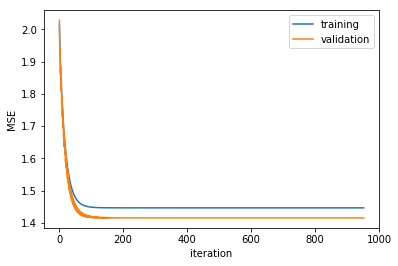

In [14]:
print("EXPERIMENT A")
print("------------")

baseline0 = ['controversiality', 'children', 'is_root']
w_0 = np.zeros((len(baseline0),1), dtype=np.float32)
# w_0 = np.ones((len(feature_set),1), dtype=np.float32)
# w_0 = np.random.uniform(-1,1,(len(feature_set),1))
beta = 1
nu = 0.00005 
k = 2000
tol = 1e-7
max_iter = 2000

linear_regression(data, baseline0, method='cf')
linear_regression(data, baseline0, method='gd', w_0=w_0, beta=beta, nu=nu, k=k, tol=tol, max_iter=max_iter)
print("")

## Experiment B
### No text  - Top 60 - Top 160

In [15]:
print("EXPERIMENT B")
print("------------")

all_features = list(data['X_train'].columns.values)
feature_set1 = all_features[0:61] + baseline0
feature_set2 = all_features[0:161] + baseline0

linear_regression(data, baseline0, method='cf', name='NO TEXT')
linear_regression(data, feature_set1, method='cf', name='TOP 60')
linear_regression(data, feature_set2, method='cf', name='TOP 160')
print("")

baseline = feature_set1

EXPERIMENT B
------------
[NO TEXT][CF] run time: 0.001 -- mse: 1.446166 | 1.414986
[TOP 60][CF] run time: 0.0129 -- mse: 1.060328 | 0.983042
[TOP 160][CF] run time: 0.0425 -- mse: 1.047676 | 0.994075



## Experiment C
### Testing basic additional features


In [16]:
print("EXPERIMENT C")
print("------------")

additional_features1 = ['text_len', 'word_count','log_text_len', 
                        'log_word_count','sum_top_words','avg_word_len']

good_features1 = univariable_analysis(data, baseline, additional_features1) 
print("")
print("The following features improve the baseline on the validation set:")
print(good_features1)   
print("")

EXPERIMENT C
------------
[baseline][CF] run time: 0.0107 -- mse: 1.060328 | 0.983042
[text_len][CF] run time: 0.0099 -- mse: 1.060303 | 0.983496
[word_count][CF] run time: 0.0067 -- mse: 1.060308 | 0.982556
[log_text_len][CF] run time: 0.0133 -- mse: 1.059023 | 0.980496
[log_word_count][CF] run time: 0.0068 -- mse: 1.059015 | 0.980408
[sum_top_words][CF] run time: 0.0062 -- mse: 1.060324 | 0.982996
[avg_word_len][CF] run time: 0.006 -- mse: 1.06032 | 0.9829

The following features improve the baseline on the validation set:
['word_count', 'log_text_len', 'log_word_count', 'sum_top_words', 'avg_word_len']



## Experiment D
### Testing complex  additional  features

In [17]:
print("EXPERIMENT D")
print("------------")

additional_features2 = ['avg_pron','avg_adv','avg_adj',
                        'avg_noun','avg_verb','profanity']

good_features2 = univariable_analysis(data, baseline, additional_features2) 
print("")
print("The following features improve the baseline on the validation set:")
print(good_features2)   
print("")

EXPERIMENT D
------------
[baseline][CF] run time: 0.0096 -- mse: 1.060328 | 0.983042
[avg_pron][CF] run time: 0.0074 -- mse: 1.060108 | 0.981902
[avg_adv][CF] run time: 0.0072 -- mse: 1.06032 | 0.983216
[avg_adj][CF] run time: 0.0068 -- mse: 1.060219 | 0.981863
[avg_noun][CF] run time: 0.0094 -- mse: 1.059847 | 0.982831
[avg_verb][CF] run time: 0.0107 -- mse: 1.060084 | 0.98304
[profanity][CF] run time: 0.0059 -- mse: 1.060317 | 0.982963

The following features improve the baseline on the validation set:
['avg_pron', 'avg_adj', 'avg_noun', 'avg_verb', 'profanity']



## Experiment E
### Building the best model

In [19]:
print("EXPERIMENT E")
print("------------")

best_model = forward_selection(data, baseline, good_features1 + good_features2)
print("")
print("The 2 features that show the best improvement are:")
print(best_model)   
print("")

EXPERIMENT E
------------
[CF] run time: 0.009 -- mse: 1.060328 | 0.983042
[word_count][CF] run time: 0.0065 -- mse: 1.060308 | 0.982556
[log_text_len][CF] run time: 0.0075 -- mse: 1.059023 | 0.980496
[log_word_count][CF] run time: 0.0075 -- mse: 1.059015 | 0.980408
[sum_top_words][CF] run time: 0.0093 -- mse: 1.060324 | 0.982996
[avg_word_len][CF] run time: 0.0066 -- mse: 1.06032 | 0.9829
[avg_pron][CF] run time: 0.0074 -- mse: 1.060108 | 0.981902
[avg_adj][CF] run time: 0.0052 -- mse: 1.060219 | 0.981863
[avg_noun][CF] run time: 0.0049 -- mse: 1.059847 | 0.982831
[avg_verb][CF] run time: 0.005 -- mse: 1.060084 | 0.98304
[profanity][CF] run time: 0.0044 -- mse: 1.060317 | 0.982963
[word_count][CF] run time: 0.0096 -- mse: 1.059014 | 0.980519
[log_text_len][CF] run time: 0.0061 -- mse: 1.05899 | 0.980394
[sum_top_words][CF] run time: 0.0059 -- mse: 1.059011 | 0.980455
[avg_word_len][CF] run time: 0.006 -- mse: 1.058997 | 0.980552
[avg_pron][CF] run time: 0.0067 -- mse: 1.058951 | 0.979

## Best model results


In [20]:
print("FINAL RESULT")
print("--------------")

linear_regression(data, baseline0, method='cf', name='NO TEXT', test=True)
linear_regression(data, feature_set1, method='cf', name='TOP 60', test=True)
linear_regression(data, feature_set2, method='cf', name='TOP 160', test=True)
linear_regression(data, best_model, method='cf', name='BEST MODEL', test=True)
print("")

FINAL RESULT
--------------
[NO TEXT][CF] run time: 0.001 -- mse: 1.446166 | 1.414986 | 1.601948
[TOP 60][CF] run time: 0.0077 -- mse: 1.060328 | 0.983042 | 1.287696
[TOP 160][CF] run time: 0.0251 -- mse: 1.047676 | 0.994075 | 1.319179
[BEST MODEL][CF] run time: 0.0133 -- mse: 1.058956 | 0.979597 | 1.282783



### Correlation Analysis

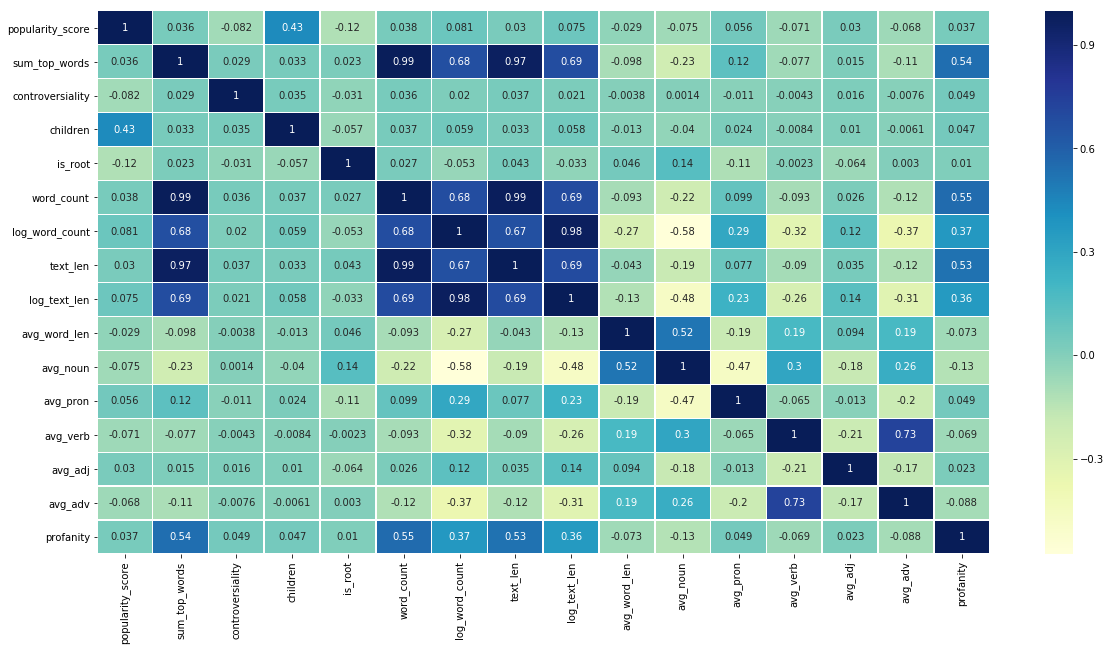

In [21]:
y_train = pd.DataFrame(data['y_train'].values, columns=['popularity_score'])
df = pd.concat([y_train, data['X_train']], axis=1)
corr = df[['popularity_score'] + all_features[161:]].corr()
plt.figure(figsize = (20,10))
ax = sns.heatmap(corr, annot=True,cmap="YlGnBu", linewidths=.5)
plt.savefig('corr_matrix')
plt.show()

In [22]:
stop = timeit.default_timer()
print('Total run time: '+ str(round(stop-start,6)))

Total run time: 177.591079
